In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Final Project - Building Recommender System for Restaurant Rating Prediction**

### **Dataset Information**
In this final project, I use Restaurant Data with Consumer Ratings from Kaggle(https://www.kaggle.com/datasets/uciml/restaurant-data-with-consumer-ratings). There are nine data files: five files are information about restaurants, three files are about the customers, and one is the user-item ratings. But we are not going to use all files in this prediction project.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from surprise import Dataset, Reader
from surprise import SVD, SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise.model_selection import cross_validate

### **1. Exploratory Data Analysis (EDA)**

In [7]:
rt_ratings = pd.read_csv("/content/drive/MyDrive/archive/rating_final.csv")
rt_location = pd.read_csv("/content/drive/MyDrive/archive/geoplaces2.csv")
ratings = pd.merge(rt_ratings,rt_location)
ratings = ratings[['userID', 'placeID', 'name','rating', 'food_rating', 'service_rating']]

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1161 entries, 0 to 1160
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userID          1161 non-null   object
 1   placeID         1161 non-null   int64 
 2   name            1161 non-null   object
 3   rating          1161 non-null   int64 
 4   food_rating     1161 non-null   int64 
 5   service_rating  1161 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 63.5+ KB


In [9]:
ratings.nunique()

userID            138
placeID           130
name              129
rating              3
food_rating         3
service_rating      3
dtype: int64

We have 138 users in this dataset and they rated a total number of 130 restaurants, however, we saw here the number of placeID doesn't match the number of restaurant name. So we run below chunk to find out that we have two restaurants both named "Gorditas Dona Tota". Since their placeIDs were different, I will treat them as different restaurants.

In [57]:
rtnames = []
for location in rt_location.name:
    if location not in rtnames:
        rtnames.append(location)
    else:
        print(location)

Gorditas Dona Tota


<Axes: xlabel='rating', ylabel='count'>

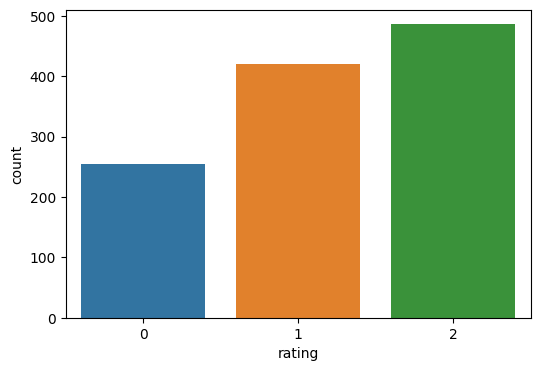

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x=ratings.rating)

<Axes: xlabel='food_rating', ylabel='count'>

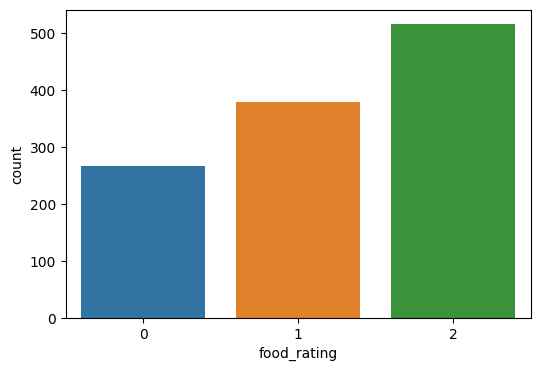

In [12]:
plt.figure(figsize=(6,4))
sns.countplot(x=ratings.food_rating)

<Axes: xlabel='service_rating', ylabel='count'>

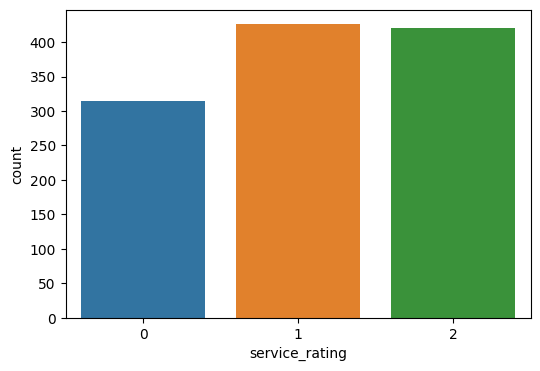

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(x=ratings.service_rating)

In [14]:
ratings.placeID.value_counts()

135085    36
132825    32
135032    28
135052    25
132834    25
          ..
135011     3
132717     3
134975     3
132668     3
132766     3
Name: placeID, Length: 130, dtype: int64

In [15]:
ratings.userID.value_counts()

U1061    18
U1106    18
U1134    16
U1024    15
U1022    14
         ..
U1070     3
U1074     3
U1039     3
U1011     3
U1138     3
Name: userID, Length: 138, dtype: int64

In [37]:
ratings.isnull().sum()

userID            0
placeID           0
name              0
rating            0
food_rating       0
service_rating    0
dtype: int64

#### EDA summarize
According to our EDA, there are no null values, which saved us some times for data cleaning. we saw the dataset contains 130 restaurants were rated at least three times on a scale of 0 to 2; it contains 138 users and they rated at least 3 restaurants.

### **Popularity-Based Recommender System**

Recommend the most popular restaurants: First we use groupby restaurant names to calculate how many users rated the restaurant, and the retaurants total ratings accordingly, and the mean of the ratings. Then, we sorted the restaurants by the total ratings in decending order, and show the top 10 most popular restaurants. Lastly, we want to find out the top5 higest average rating restaurants in the top 10 most popular restaurants.

In [16]:
grouped = ratings.groupby("name").aggregate({"rating": [np.size, np.sum, np.mean]})
popular = grouped.sort_values(("rating", "size"), ascending=False)

top_10_visit = popular.sort_values(("rating","size"), ascending=False)[:10]
print("Top 10 most popular restaurants")
print(top_10_visit)

Top 10 most popular restaurants
                                   rating              
                                     size sum      mean
name                                                   
Tortas Locas Hipocampo                 36  48  1.333333
puesto de tacos                        32  41  1.281250
Cafeteria y Restaurant El Pacifico     28  33  1.178571
La Cantina Restaurante                 25  32  1.280000
Gorditas Doa Gloria                    25  25  1.000000
Restaurant la Chalita                  24  29  1.208333
Restaurante Marisco Sam                22  25  1.136364
Restaurante El Cielo Potosino          21  26  1.238095
Restaurant Oriental Express            20  25  1.250000
La Posada del Virrey                   18  25  1.388889


<ipython-input-17-09680d5ef9b9>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


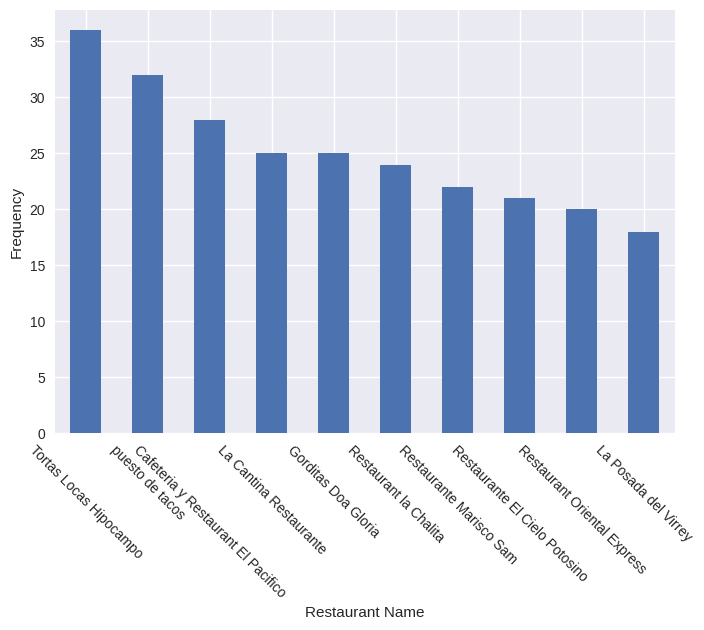

In [17]:
plt.style.use('seaborn')
top_10_visit["rating"]["size"].plot(kind='bar')
plt.xlabel("Restaurant Name")
plt.ylabel("Frequency")
plt.xticks(rotation=-45)
plt.show()

In [19]:
print("Top 5 highest rating restaurants in top 10 most popular restaurants")
top_10_visit.sort_values(("rating", "mean"), ascending=False)[:5]

Top 5 highest rating restaurants in top 10 most popular restaurants


rating              
                              size sum      mean
name                                            
La Posada del Virrey            18  25  1.388889
Tortas Locas Hipocampo          36  48  1.333333
puesto de tacos                 32  41  1.281250
La Cantina Restaurante          25  32  1.280000
Restaurant Oriental Express     20  25  1.250000

By viewing above information, according to popularity based recommender system: if we have a new user and we don't have any information about this user, we may recommend the most popular restaurant which is Tortas Locas Hipocampo, or we can recommend the highest rating restaurant in the top10 most popular restaurant list, which is La Posada del Virrey.

### **Collaborative Filtering**
Here we are going to use two methods, one is SVD(metrix factorization) and the other is KNN. The KNN works by calculating the similarity between each pair of items, and then using the similarities to predict what rating will a user give to the item. The SVD methods is use for sparse matrix, it is the factorization of this matrix into the product of three matrices.


In [21]:
reader = Reader(rating_scale=(0,2))
ratings_matrix = Dataset.load_from_df(ratings[['userID', 'placeID', 'rating']], reader)

In [53]:
svd = SVD(verbose=True, n_epochs=100)
svd_res = cross_validate(svd, ratings_matrix, measures=['RMSE'], cv=3, verbose=True)
svd_res

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

{'test_rmse': array([0.67720955, 0.67569998, 0.65159478]),
 'fit_time': (0.1399672031402588, 0.14397764205932617, 0.13923072814941406),
 'test_time': (0.005023956298828125,
  0.005513668060302734,
  0.003957271575927734)}

In [54]:
knn = KNNWithMeans(k=100)
knn_res = cross_validate(knn, ratings_matrix, measures=['RMSE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7079  0.6779  0.7271  0.7043  0.0203  
Fit time          0.01    0.00    0.00    0.01    0.01    
Test time         0.01    0.01    0.00    0.01    0.00    


In [55]:
results = np.array((svd_res['test_rmse'], knn_res['test_rmse']))
results
df_result = pd.DataFrame(results, index=['SVD', 'KNN'], columns = ['RMSE_fold1', 'RMSE_fold2', 'RMSE_fold3'])
df_result['RMSE Mean'] = df_result[['RMSE_fold1', 'RMSE_fold2', 'RMSE_fold3']].mean(axis=1)

In [56]:
df_result.sort_values(by='RMSE Mean')

,RMSE_fold1,RMSE_fold2,RMSE_fold3,RMSE Mean
SVD,0.677210,0.675700,0.651595,0.668168
KNN,0.707899,0.677901,0.727143,0.704314


### Summary
To sum up, popularity-based recommender system is based on frequency counts, so it is not a personalised recommendation. For example, if we have five new users, and all users will be recommended to the same places. However, collaborative filtering based model will list the restaurants based on the user's past ratings.
Based on RMSE for KNN and SVD model, the rmse values in SVD model is better than it in KNN algorithm.